## Imports and functions

In [1]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [2]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
#     temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
#     temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
#     temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum
    
#this is to not calculate aggregates if at least one value on the main factor column is NaN
def apply_condition(group,main_factor,agg_function):
    if group[main_factor].isnull().any():
        return np.nan
    else:
        return agg_function(group[main_factor])

def create_ph_aggregated_factors(ph_df, main_factor, agg_function, function_name, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    agg_df[f'{env_type}-transfer_feeding-{function_name}'] = ph_df[before_transfer & after_first_feeding] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-transfer_vaccination-{function_name}'] = ph_df[before_transfer & after_vaccination]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date
        agg_df[f'{env_type}-{week}_weeks_before_transfer-{function_name}'] = ph_df[before_transfer & condition]\
        .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})

    for col in agg_df.columns[:]:
        agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
        agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_degree_days_aggregated_factor(ph_df, main_factor, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    days = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df['fw_cycle_length'] = days['diff']
    agg_df[f'{env_type}-transfer_feeding-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-transfer_vaccination-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-vaccination_feeding-degree_days'] = days['diff'] * degrees['mean']

    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date

        days = ph_df[before_transfer & condition].groupby('final_locus_population_id')['event_date'] \
        .agg(['max','min'])
        days['diff'] = (days['max'] - days['min']).dt.days
        degrees = ph_df[before_transfer & condition].groupby('final_locus_population_id')[main_factor] \
        .agg(['mean'])
        agg_df[f'{env_type}-{week}_weeks_before_transfer-degree_days'] = days['diff'] * degrees['mean']

#     mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})
    
#     for col in agg_df.columns[:]:
#         agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
#         agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_ph_aggregated_factors_threshold(ph_df, main_factor, lower_bound, upper_bound, agg_function, condition_type, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    higher_max = f'{env_type}-{condition_type}-higher_max-{upper_bound}'
    lower_min = f'{env_type}-{condition_type}-lower_min-{lower_bound}'
    btw_min_max = f'{env_type}-{condition_type}-btw_min_max-{lower_bound}-{upper_bound}'
    
    relative_higher_max = f'{env_type}-{condition_type}-relative_higher_max-{upper_bound}'
    relative_lower_min = f'{env_type}-{condition_type}-relative_lower_min-{lower_bound}'
    relative_out_min_max = f'{env_type}-{condition_type}-relative_out_min_max-{lower_bound}-{upper_bound}'


    agg_df[higher_max] = ph_df[ph_df[main_factor] > upper_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[lower_min] = ph_df[ph_df[main_factor] < lower_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[btw_min_max] = ph_df[ph_df[main_factor].between(lower_bound, upper_bound)]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df['measurements_count'] = ph_df.groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[higher_max] = agg_df[higher_max].fillna(0).astype('int64')
    agg_df[lower_min] = agg_df[lower_min].fillna(0).astype('int64')
    agg_df[btw_min_max] = agg_df[btw_min_max].fillna(0).astype('int64')

    
    agg_df[relative_higher_max] = agg_df[higher_max] / agg_df['measurements_count']
    agg_df[relative_lower_min] =  agg_df[lower_min] /  agg_df['measurements_count']
    agg_df[relative_out_min_max] = 1 - (agg_df[btw_min_max] /agg_df['measurements_count'])
    agg_df.drop(columns='measurements_count', inplace=True)
        
    return agg_df

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

def plot_factors(factors_df, path):
    pairplot = sns.pairplot(factors_df[np.append(corr_df.index, 'mortality')], size=(20, 15))
    plt.title('Mortality vs feature pairplot')
    plt.show()

    for ax in pairplot.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        # set y labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')
        ax.yaxis.get_label().set_horizontalalignment('right')
    pairplot.figure.savefig(path / 'mortality_vs_feature_pairplot.jpg')

def plot_swarm(df, factor, target, bins, y_scale=1):
    sns.set_style("whitegrid")

    arr_for_chart = df.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(df[factor], bins=bins)
    arr_for_chart['mortality'] = arr_for_chart['mortality']
    arr_for_chart['TGC_SW'] = arr_for_chart['TGC_SW'] / 100
    x_axis_factor = factor + '_binned'

    plt.figure()
    f, axs = plt.subplots(1, 1, figsize=(18,8), sharex=True)
    box_plot = sns.swarmplot(data=arr_for_chart, x=x_axis_factor, y=target)

    mean_target = arr_for_chart.groupby(x_axis_factor)[target].mean()
    mean_main_factor = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()

#     vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      mean_target.iloc[xtick],
                      round(mean_target.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='black',
                      weight='semibold')
        box_plot.text(xtick,
                      mean_main_factor.iloc[xtick] / y_scale,
                      round(mean_main_factor.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='darkblue',
                      weight='semibold')
    
    plt.title(f'Swarmplot: {target} vs. {factor}')
    axs.legend(
        arr_for_chart[x_axis_factor].value_counts().sort_index().apply(lambda x: 'Sample count: ' + str(x)),
        loc='upper right'
    )

    f.show()

#     f.savefig(f'swarmplot_{target}_vs_{factor}.jpg')

## Data processing

In [3]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/FW_temperature_cleared.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final_locus.csv',
                       mortality_path='../data/smolt_dataset_transfers_until2023Feb28_narrow.csv')

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
vaccines = pd.read_csv('../data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = pd.DataFrame(vaccines.groupby('FINAL_LOCUS_POPULATION_ID')['VAC_EVENT_DATE'].max())
fresh_water_dates.rename(columns={'pretransfer_fw_locus_population_id': 'final_locus_population_id'}, inplace=True)
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
temperature['event_year'] = temperature['event_date'].dt.year

In [4]:
fw_mortality = pd.read_csv('fw_mortality_final_lp_grouped_upd.csv')

In [5]:
fw_mortality = fw_mortality.merge(
    fresh_water_dates,
    how='inner',
)

fw_mortality = fw_mortality.merge(
    vaccines_agg,
    left_on='final_locus_population_id',
    right_on='FINAL_LOCUS_POPULATION_ID',
    how='inner'
)

fw_mortality['shipout_year'] = fw_mortality['shipout_date'].dt.year

In [6]:
mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)

mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [7]:
before_transfer = fw_mortality['event_date'] < fw_mortality['shipout_date']

after_vaccination = fw_mortality['event_date'] > fw_mortality['VAC_EVENT_DATE']
before_vaccination = fw_mortality['event_date'] < fw_mortality['VAC_EVENT_DATE']

after_first_feeding = fw_mortality['event_date'] > fw_mortality['first_feeding_date']

six_weeks_condition = fw_mortality['event_date'] > (fw_mortality['shipout_date'] - pd.to_timedelta(6, unit='W'))
eight_weeks_condition = fw_mortality['event_date'] > (fw_mortality['shipout_date'] - pd.to_timedelta(8, unit='W'))
threshold_conditions = {
    '6_weeks_before_transfer': before_transfer & six_weeks_condition,
    '8_weeks_before_transfer': before_transfer & eight_weeks_condition,
    'vaccination_transfer': before_transfer & after_vaccination,
    'first_feeding_transfer': before_transfer & after_first_feeding,
}

weeks_before_transfer = [2, 4, 6, 8]
#name of column with values of the factor
key_columns = ['locus_id','fish_group_id','transfer_year']

## Factors aggregation

In [8]:
main_factor = 'mortality_rate'

In [9]:
agg_functions = {
    'mean': np.mean,
    'min': np.min,
    'max': np.max,
    'std': np.std,
    'cv': lambda x: np.std(x) / np.mean(x),  # coefficient of variation
#     'threshold': np.count_nonzero,
    'median': np.median,
    'sum': np.sum
}

In [10]:
display(fw_mortality[fw_mortality[main_factor].isin([np.inf, -np.inf])])

display(fw_mortality[fw_mortality[main_factor].isna()])

,final_locus_population_id,event_date,mortality_rate,pretransfer_fw_locus_id,first_movement_date,first_feeding_date,shipout_date,VAC_EVENT_DATE,shipout_year


,final_locus_population_id,event_date,mortality_rate,pretransfer_fw_locus_id,first_movement_date,first_feeding_date,shipout_date,VAC_EVENT_DATE,shipout_year


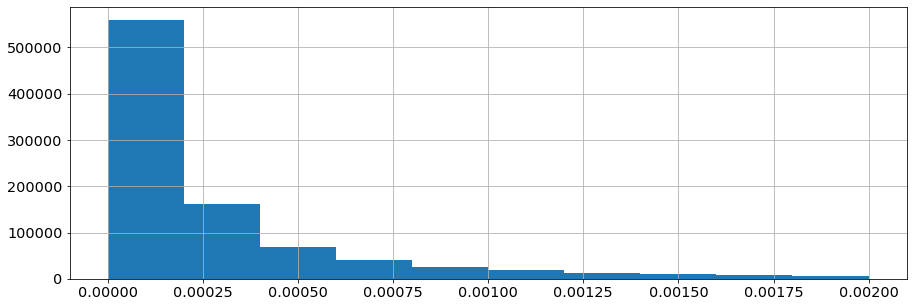

In [11]:
if True:
    fw_mortality[fw_mortality[main_factor] < 0.002][main_factor].hist()
#     fw_mortality[main_factor].quantile(0.)
#     max_threshold = 14  # quantile 0.8
#     min_threshold
#     print(f'Min {main_factor} threshold: {min_threshold}, max {main_factor} threshold: {max_threshold}')

In [12]:
agg_dfs = []

for name, func in tqdm(agg_functions.items()):
    if name != 'threshold':
        agg_df = create_ph_aggregated_factors(fw_mortality,
                                              main_factor,
                                              agg_function=func,
                                              function_name=name,
                                              env_type=main_factor.lower())
        agg_dfs.append(agg_df)
    else:
        for condition_type, condition in threshold_conditions.items():
            agg_df = create_ph_aggregated_factors_threshold(
                fw_mortality[condition],
                main_factor,
                min_threshold,
                max_threshold,
                agg_function=func,
                condition_type=condition_type,
                env_type=main_factor.lower()
            )
            agg_dfs.append(agg_df)

# agg_dfs.append(create_degree_days_aggregated_factor(temperature, main_factor, env_type=main_factor.lower()))
    
agg_df = pd.concat(agg_dfs)

agg_df = agg_df.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='right')

factors = agg_df.columns.difference(
    ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
)

factors_fw_mortality = create_factors_df(agg_df,
                                        factors,
                                        key_columns, 
                                        weight_column='from_count_stocking',
                                        weighted_func=weighted_avg)
factors_fw_mortality = factors_fw_mortality.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner')

factors_fw_mortality = factors_fw_mortality.merge(
    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
    on=key_columns,
    how='inner'
)

factors_fw_mortality.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

factors_fw_mortality.to_csv(f'factors_{main_factor.lower()}.csv', index=False)

100%|█████████████████████████████████████████████| 7/7 [01:00<00:00,  8.60s/it]


Weighting factors


100%|█████████████████████████████████████████| 126/126 [04:49<00:00,  2.30s/it]


In [13]:
factors_fw_mortality

,locus_id,fish_group_id,transfer_year,mortality_rate-2_weeks_before_transfer-cv,mortality_rate-2_weeks_before_transfer-cv-from_mean,mortality_rate-2_weeks_before_transfer-cv-from_mean-abs,mortality_rate-2_weeks_before_transfer-max,mortality_rate-2_weeks_before_transfer-max-from_mean,mortality_rate-2_weeks_before_transfer-max-from_mean-abs,mortality_rate-2_weeks_before_transfer-mean,...,mortality_rate-transfer_vaccination-min-from_mean,mortality_rate-transfer_vaccination-min-from_mean-abs,mortality_rate-transfer_vaccination-std,mortality_rate-transfer_vaccination-std-from_mean,mortality_rate-transfer_vaccination-std-from_mean-abs,mortality_rate-transfer_vaccination-sum,mortality_rate-transfer_vaccination-sum-from_mean,mortality_rate-transfer_vaccination-sum-from_mean-abs,mortality,TGC_SW
0,3046036,11,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007496,2.699988
1,3046036,1052,2019,0.946352,-0.056064,0.120630,0.000070,-0.000473,0.000473,0.000018,...,-7.151571e-07,7.151571e-07,0.000211,-0.000097,0.000097,0.005210,-0.004832,0.004832,0.003943,3.291903
2,3046036,3918,2020,0.994906,-0.007510,0.007510,0.000110,-0.000432,0.000432,0.000032,...,1.188030e-06,1.188030e-06,0.000235,-0.000072,0.000072,0.003367,-0.006675,0.006675,0.007676,2.771383
3,3046036,6165,2023,1.150621,0.148204,0.148204,0.000198,-0.000345,0.000345,0.000054,...,4.225432e-07,4.225432e-07,0.000069,-0.000238,0.000238,0.003495,-0.006547,0.006547,0.005902,2.530637
4,3046043,310,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018394,2.747195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,7183889,6071,2022,0.649178,-0.353238,0.353238,0.000166,-0.000377,0.000377,0.000080,...,4.967011e-06,4.967011e-06,0.000137,-0.000170,0.000170,0.007269,-0.002773,0.002773,0.012813,3.623094
1258,7183890,6072,2022,0.836295,-0.166121,0.166121,0.000134,-0.000409,0.000409,0.000047,...,-9.813583e-07,1.357775e-06,0.000173,-0.000134,0.000134,0.005607,-0.004436,0.004436,0.014813,3.101141
1259,7183891,6072,2022,0.916989,-0.085428,0.085428,0.000116,-0.000427,0.000427,0.000039,...,8.118029e-07,8.118029e-07,0.000265,-0.000042,0.000042,0.008256,-0.001786,0.001786,0.014654,2.995160
1260,7183892,6069,2022,0.977448,-0.024969,0.078876,0.000254,-0.000289,0.000289,0.000066,...,8.465282e-07,8.465282e-07,0.000198,-0.000110,0.000110,0.006147,-0.003895,0.003895,0.022576,3.020299


In [33]:
factors_fw_mortality['mortality_rate-8_weeks_before_transfer-max-from_mean-abs'].isna().sum()

273

## Findings

In [14]:
tmp = fw_mortality.merge(mortality_final_locus,
                         left_on='final_locus_population_id',
                         right_on='from_locus_population_id')


factors_fw_mortality = factors_fw_mortality.merge(
    pd.DataFrame(tmp[key_columns+[main_factor]].groupby(key_columns)[main_factor].mean()),
    on=key_columns,
    how='left'
)

In [15]:
for col in factors_fw_mortality.columns:
    print(col)

locus_id
fish_group_id
transfer_year
mortality_rate-2_weeks_before_transfer-cv
mortality_rate-2_weeks_before_transfer-cv-from_mean
mortality_rate-2_weeks_before_transfer-cv-from_mean-abs
mortality_rate-2_weeks_before_transfer-max
mortality_rate-2_weeks_before_transfer-max-from_mean
mortality_rate-2_weeks_before_transfer-max-from_mean-abs
mortality_rate-2_weeks_before_transfer-mean
mortality_rate-2_weeks_before_transfer-mean-from_mean
mortality_rate-2_weeks_before_transfer-mean-from_mean-abs
mortality_rate-2_weeks_before_transfer-median
mortality_rate-2_weeks_before_transfer-median-from_mean
mortality_rate-2_weeks_before_transfer-median-from_mean-abs
mortality_rate-2_weeks_before_transfer-min
mortality_rate-2_weeks_before_transfer-min-from_mean
mortality_rate-2_weeks_before_transfer-min-from_mean-abs
mortality_rate-2_weeks_before_transfer-std
mortality_rate-2_weeks_before_transfer-std-from_mean
mortality_rate-2_weeks_before_transfer-std-from_mean-abs
mortality_rate-2_weeks_before_transf

### Finding 1: Mean mortality rate whole period

#### DATA IN PERCENTAGES

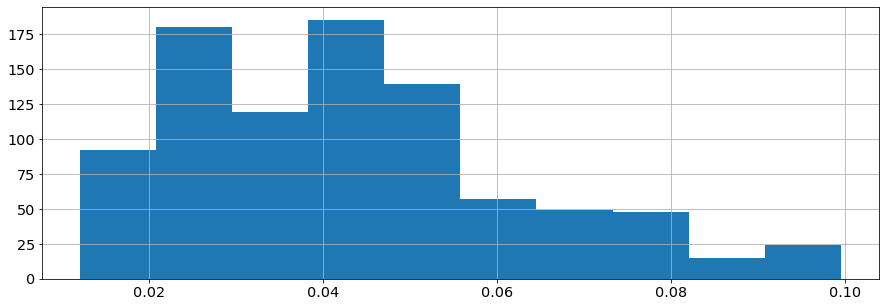

<Figure size 1080x360 with 0 Axes>

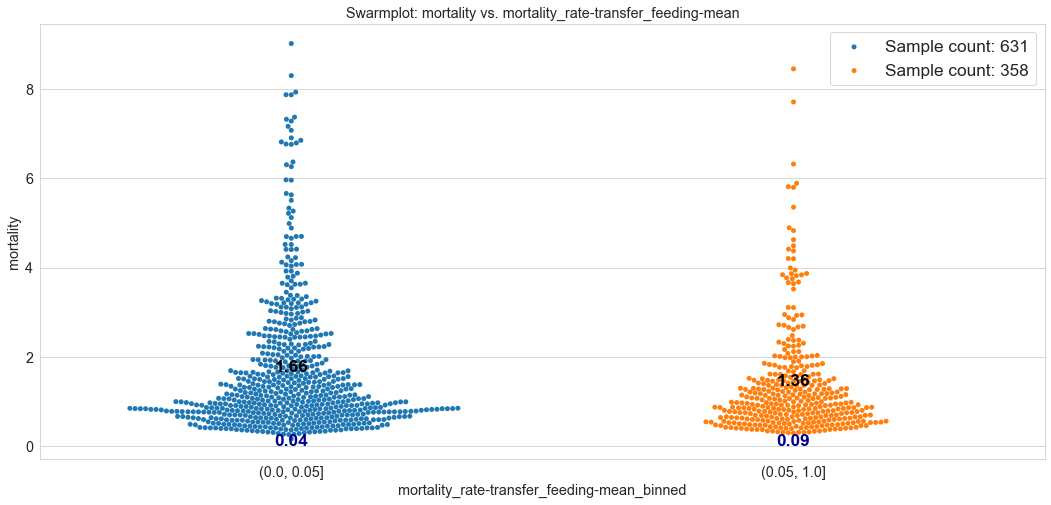

<Figure size 1080x360 with 0 Axes>

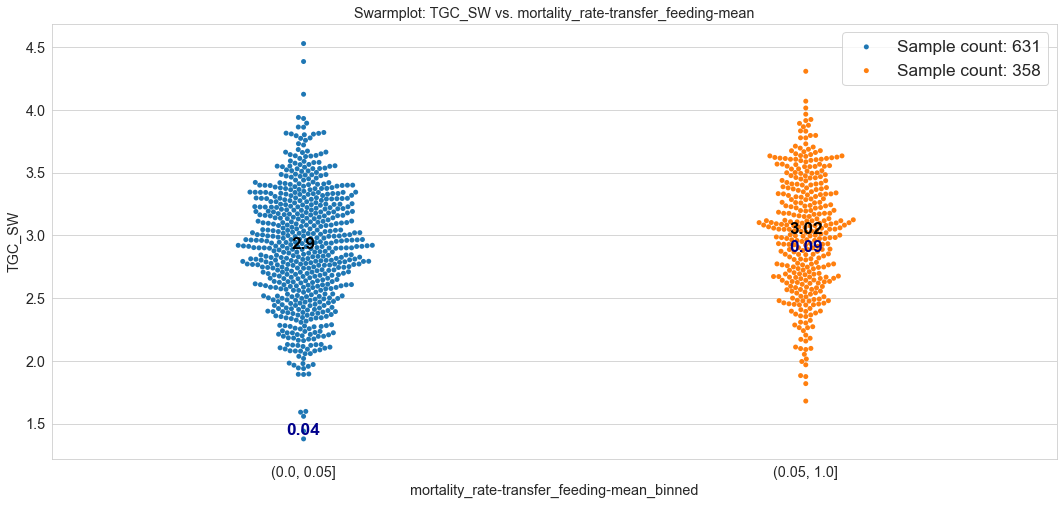

In [16]:
factor = f'{main_factor}-transfer_feeding-mean'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.001][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.05, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.05, 1),
           y_scale=0.03)

### Finding 2: Mean mortality rate last 2/4/6/8 weeks

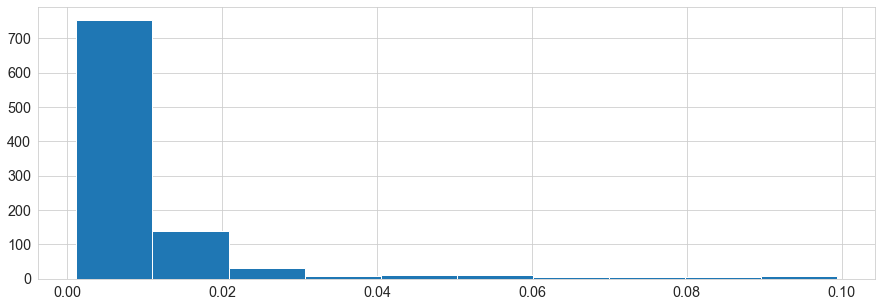

<Figure size 1080x360 with 0 Axes>

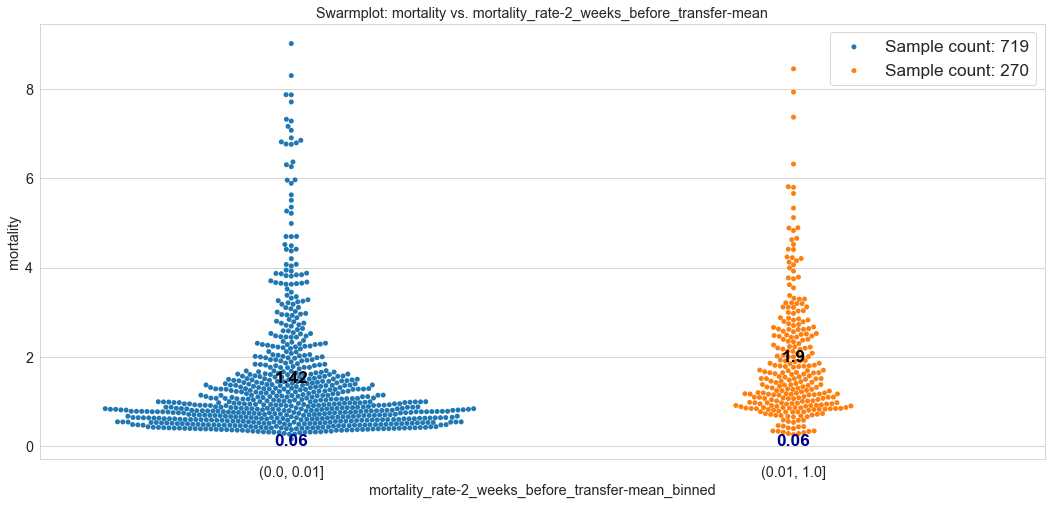

<Figure size 1080x360 with 0 Axes>

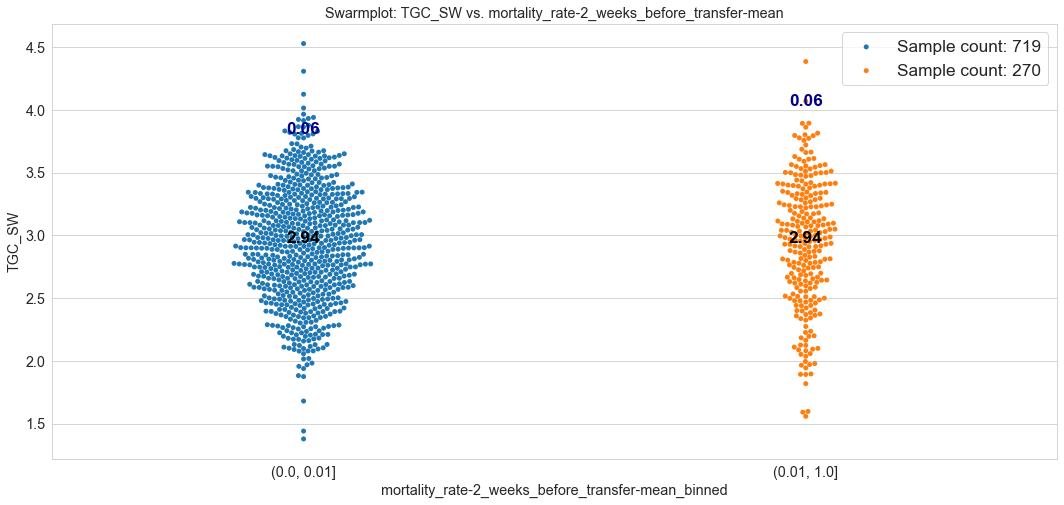

In [17]:
factor = f'{main_factor}-2_weeks_before_transfer-mean'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.001][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.01, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.01, 1),
           y_scale=0.015)

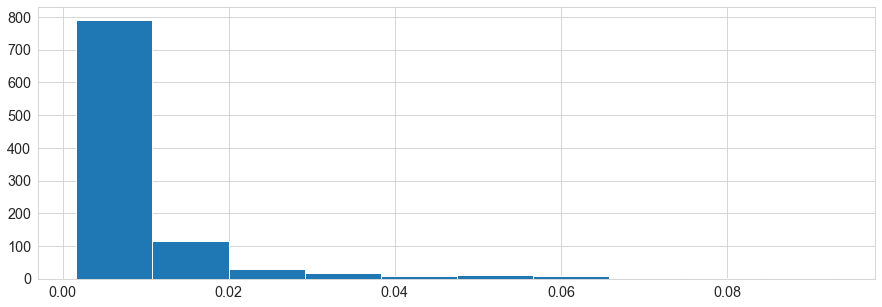

<Figure size 1080x360 with 0 Axes>

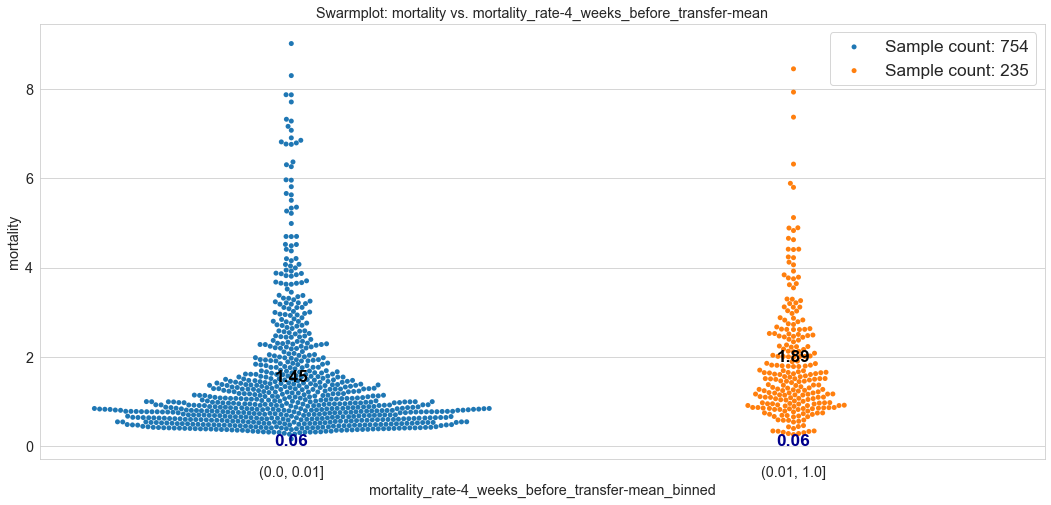

<Figure size 1080x360 with 0 Axes>

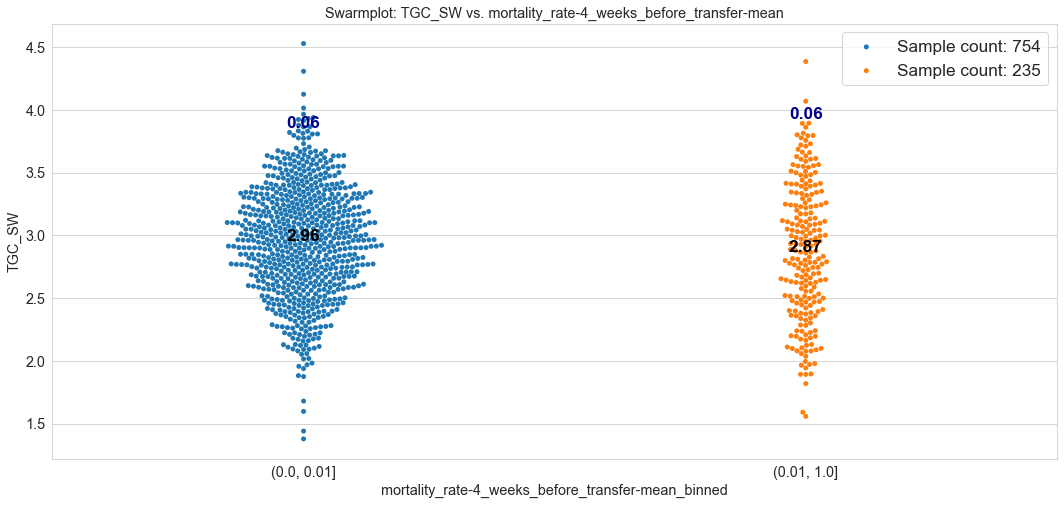

In [18]:
factor = f'{main_factor}-4_weeks_before_transfer-mean'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.001][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.01, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.01, 1),
           y_scale=0.015)

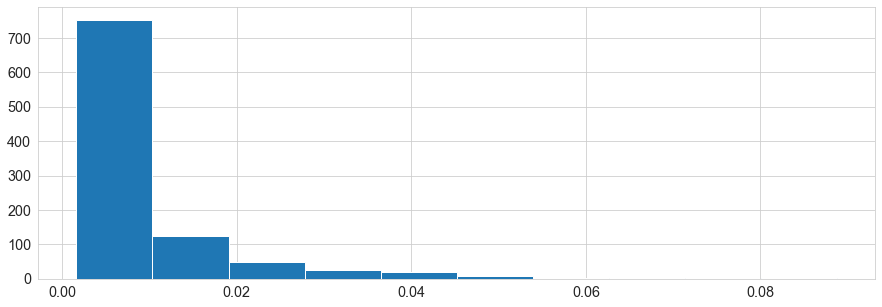

<Figure size 1080x360 with 0 Axes>

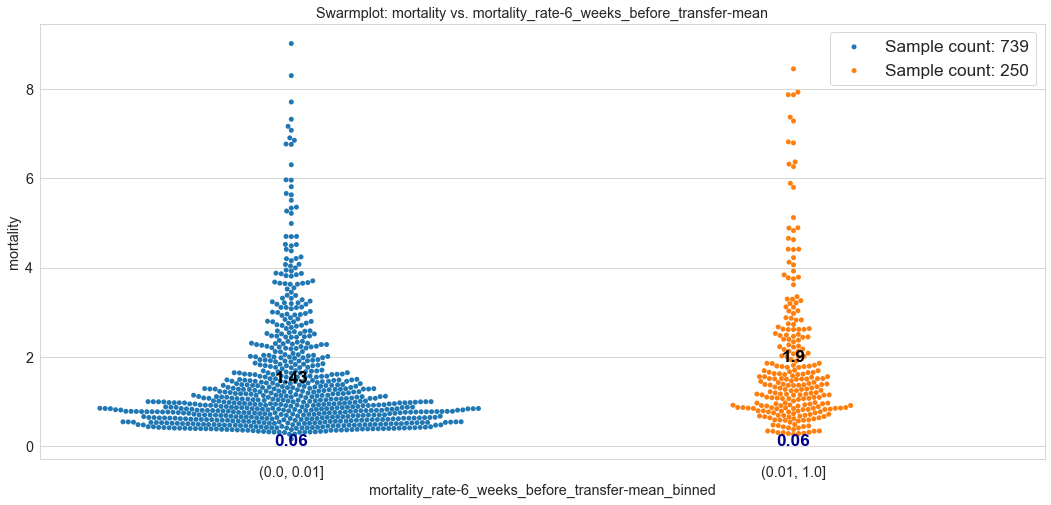

<Figure size 1080x360 with 0 Axes>

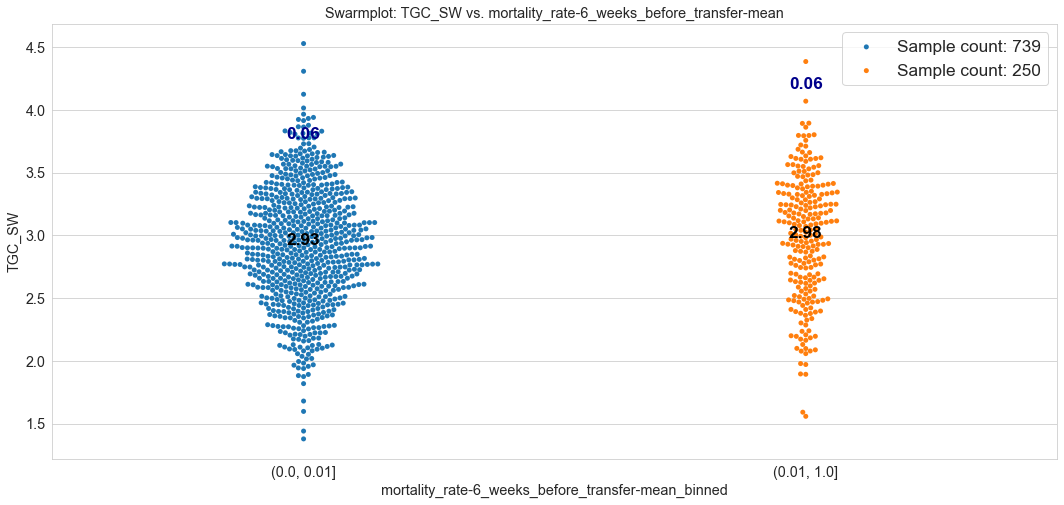

In [19]:
factor = f'{main_factor}-6_weeks_before_transfer-mean'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.001][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.01, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.01, 1),
           y_scale=0.015)

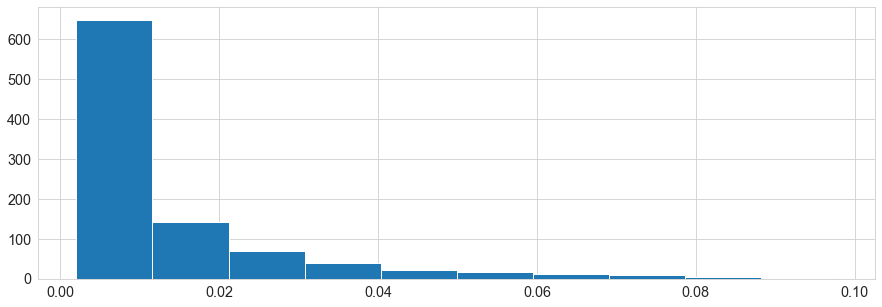

<Figure size 1080x360 with 0 Axes>

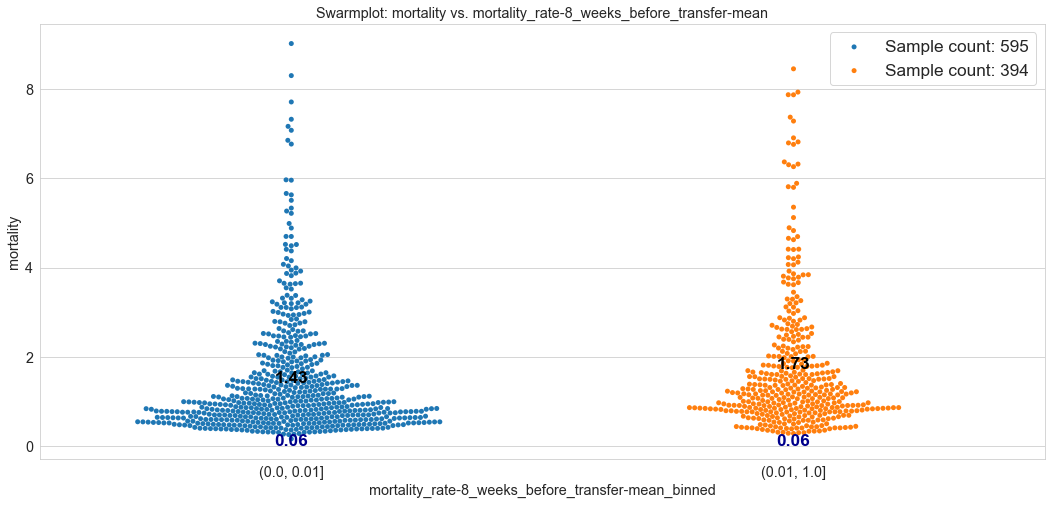

<Figure size 1080x360 with 0 Axes>

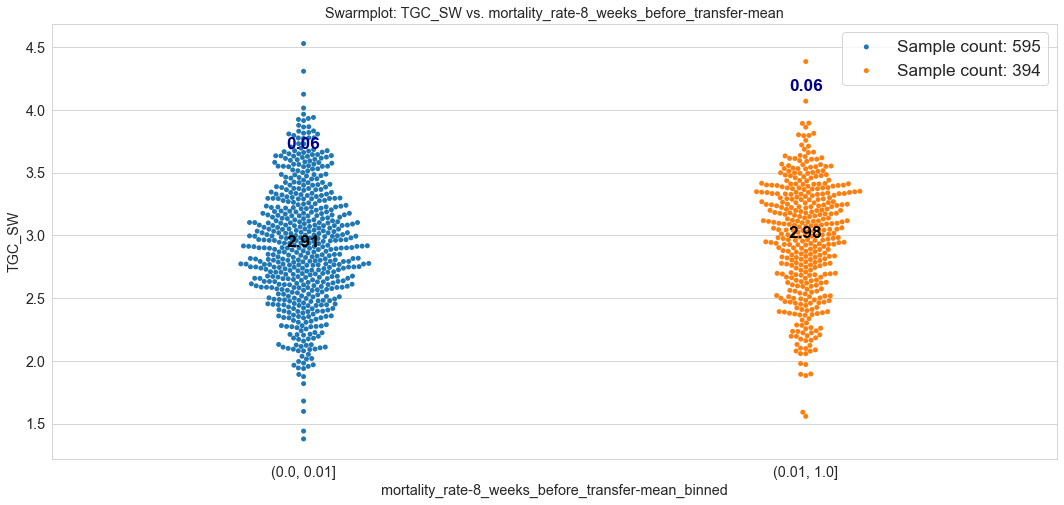

In [22]:
factor = f'{main_factor}-8_weeks_before_transfer-mean'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.001][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.01, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.01, 1),
           y_scale=0.015)

### Finding 3: Sum mortality rate last 2/4/6/8 weeks

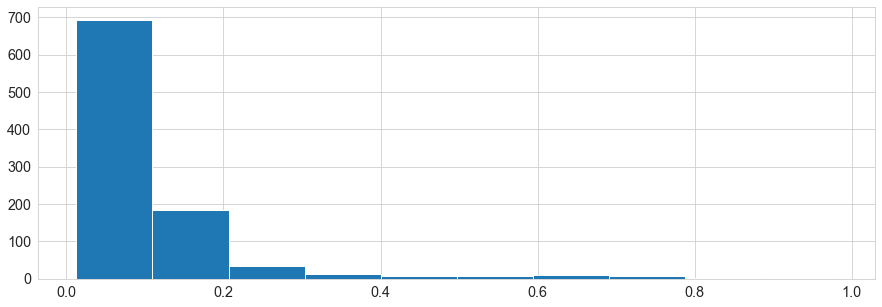

<Figure size 1080x360 with 0 Axes>

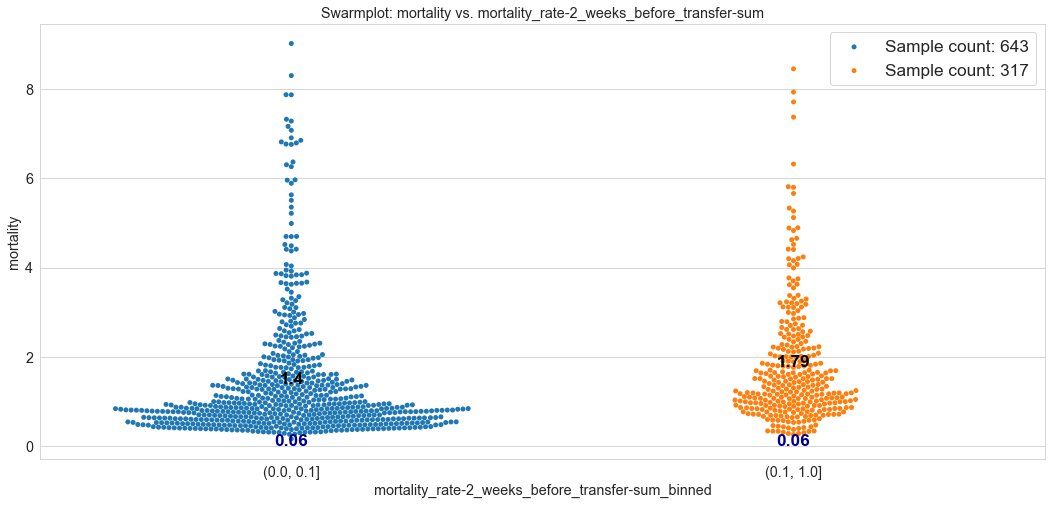

<Figure size 1080x360 with 0 Axes>

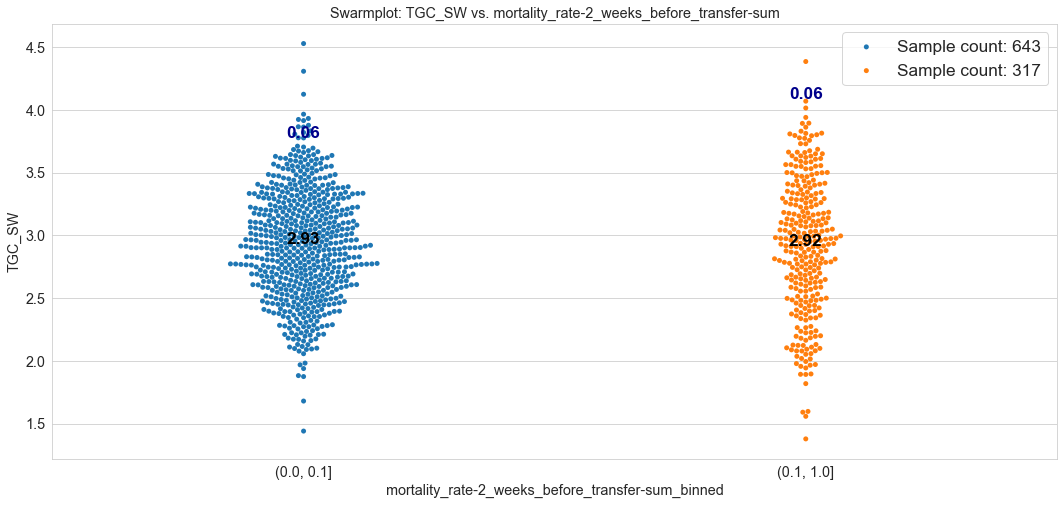

In [42]:
factor = f'{main_factor}-2_weeks_before_transfer-sum'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.01][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.1, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.1, 1),
           y_scale=0.015)

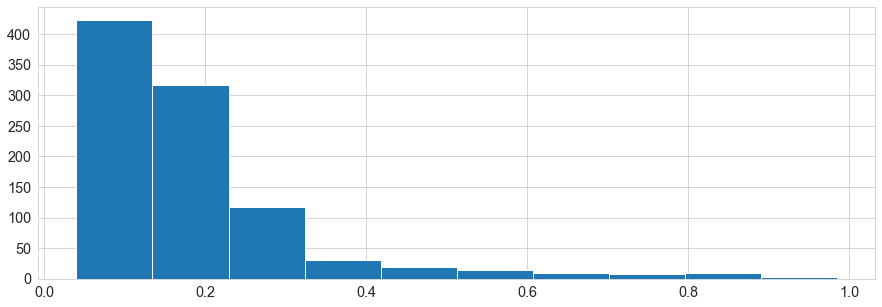

<Figure size 1080x360 with 0 Axes>

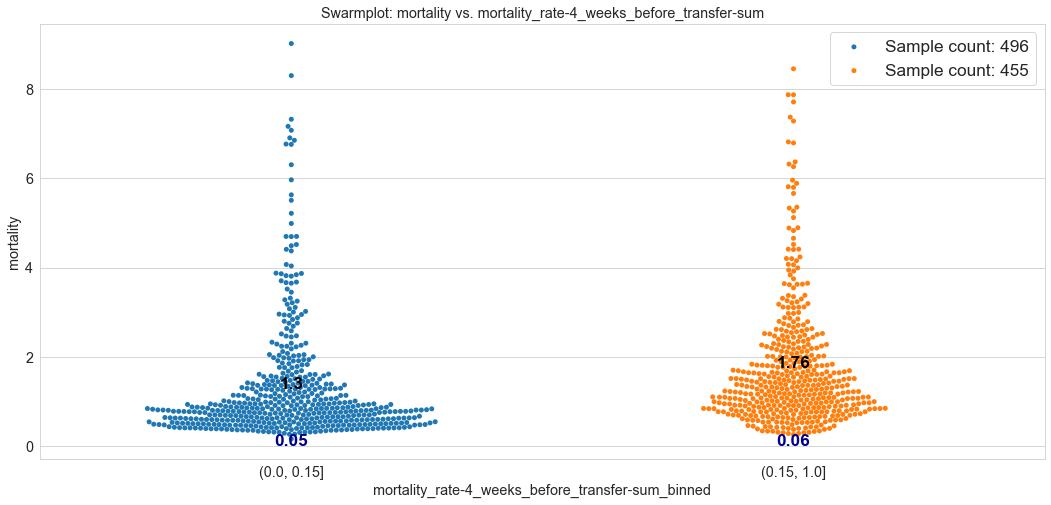

<Figure size 1080x360 with 0 Axes>

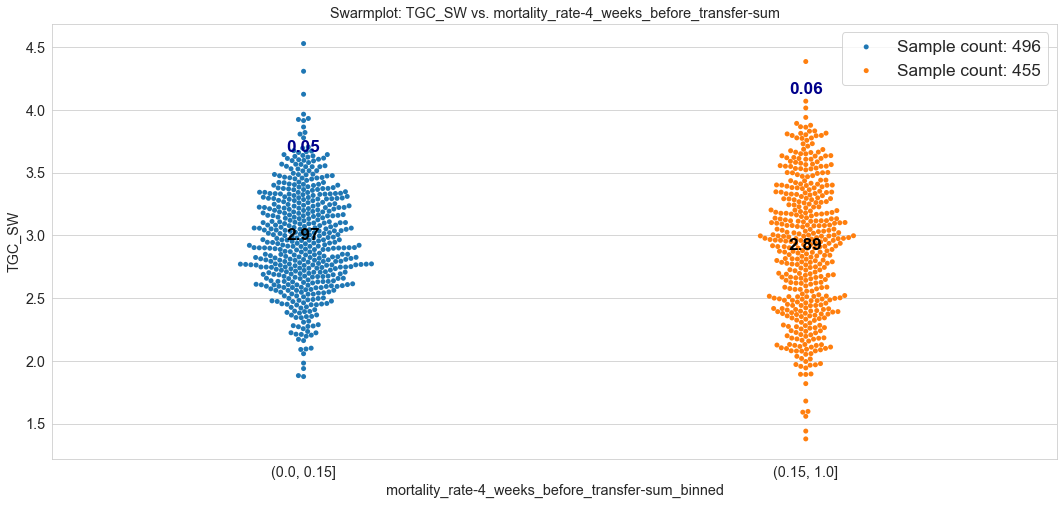

In [46]:
factor = f'{main_factor}-4_weeks_before_transfer-sum'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.01][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.15, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.15, 1),
           y_scale=0.015)

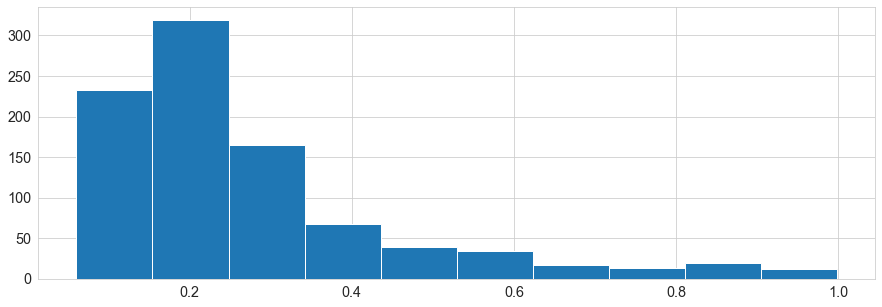

<Figure size 1080x360 with 0 Axes>

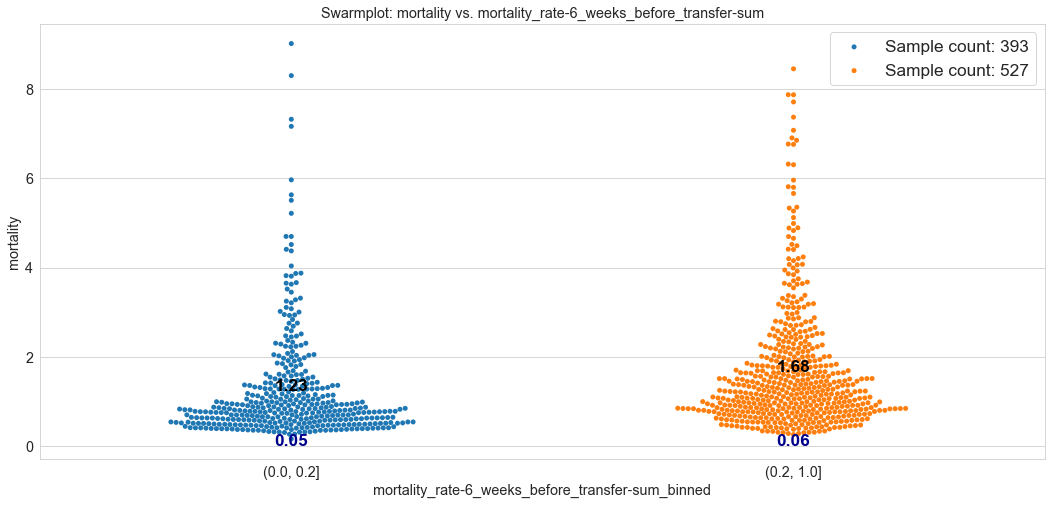

<Figure size 1080x360 with 0 Axes>

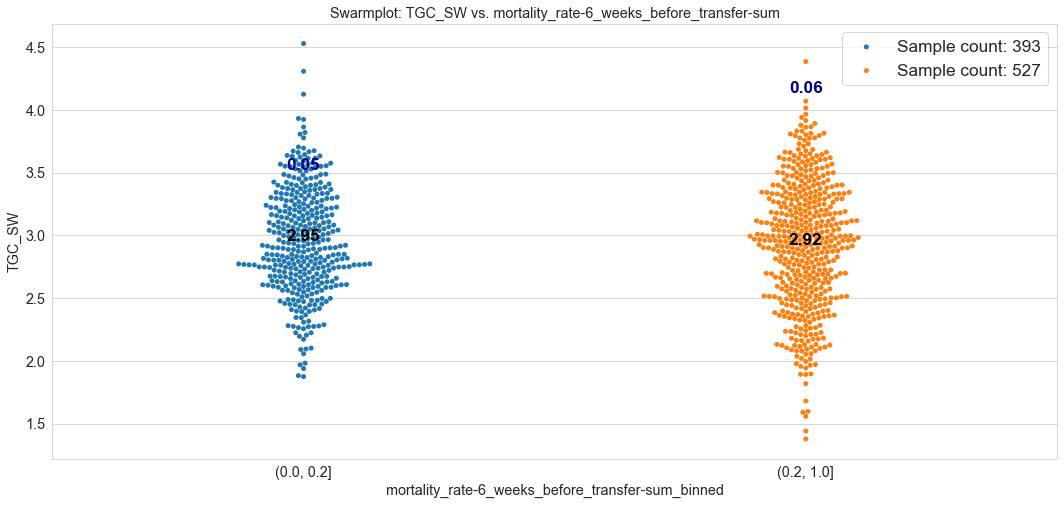

In [49]:
factor = f'{main_factor}-6_weeks_before_transfer-sum'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.01][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.2, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.2, 1),
           y_scale=0.015)

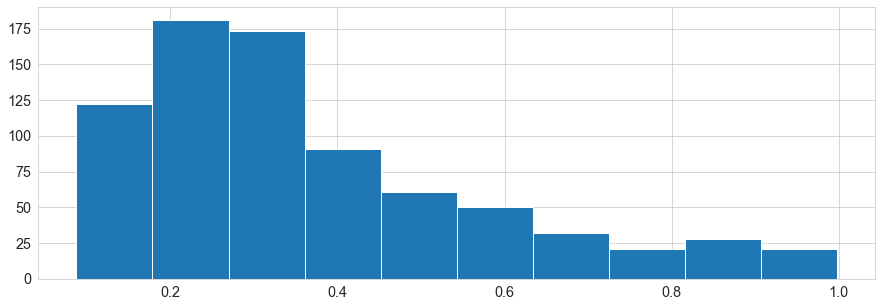

<Figure size 1080x360 with 0 Axes>

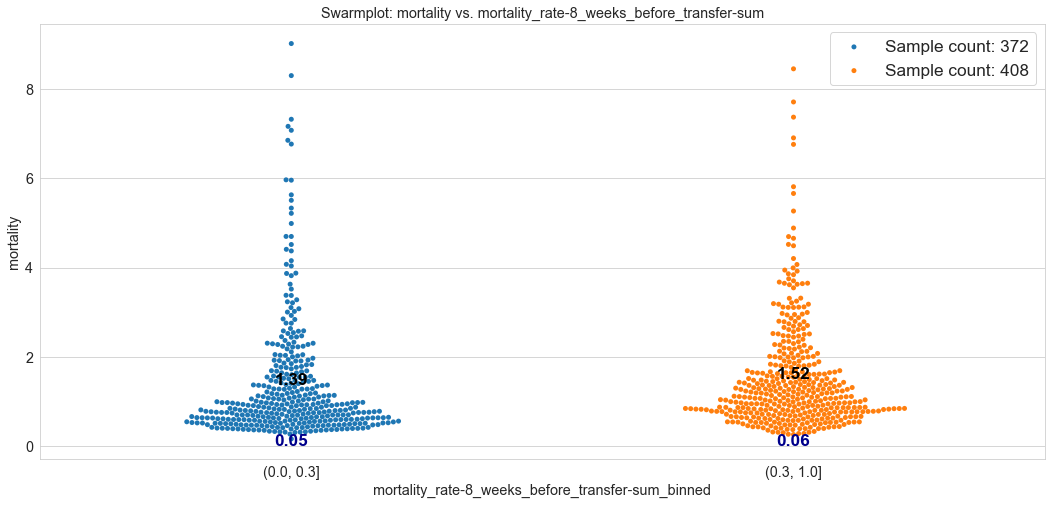

<Figure size 1080x360 with 0 Axes>

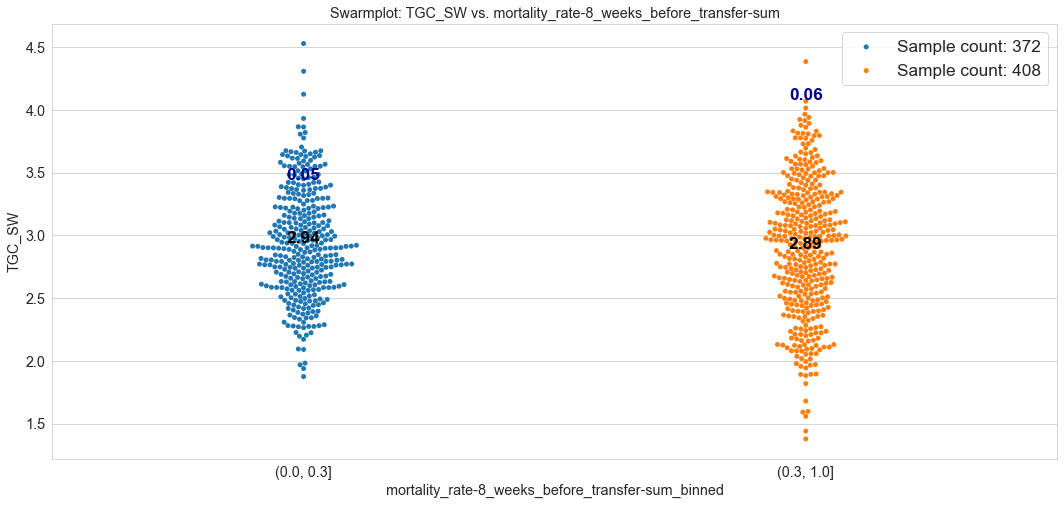

In [51]:
factor = f'{main_factor}-8_weeks_before_transfer-sum'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.01][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.3, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.3, 1),
           y_scale=0.015)

### FInding 4: Mean mortality rate transfer-vaccination

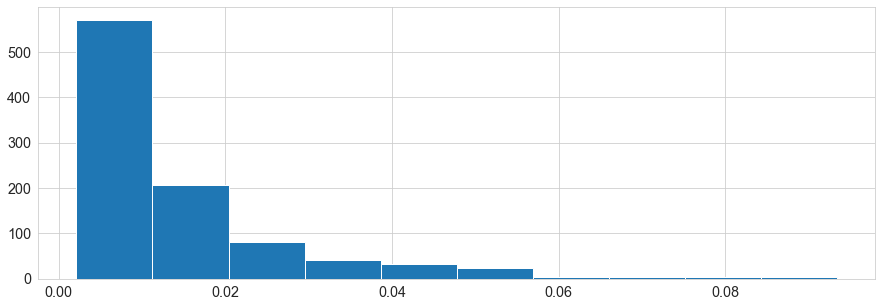

<Figure size 1080x360 with 0 Axes>

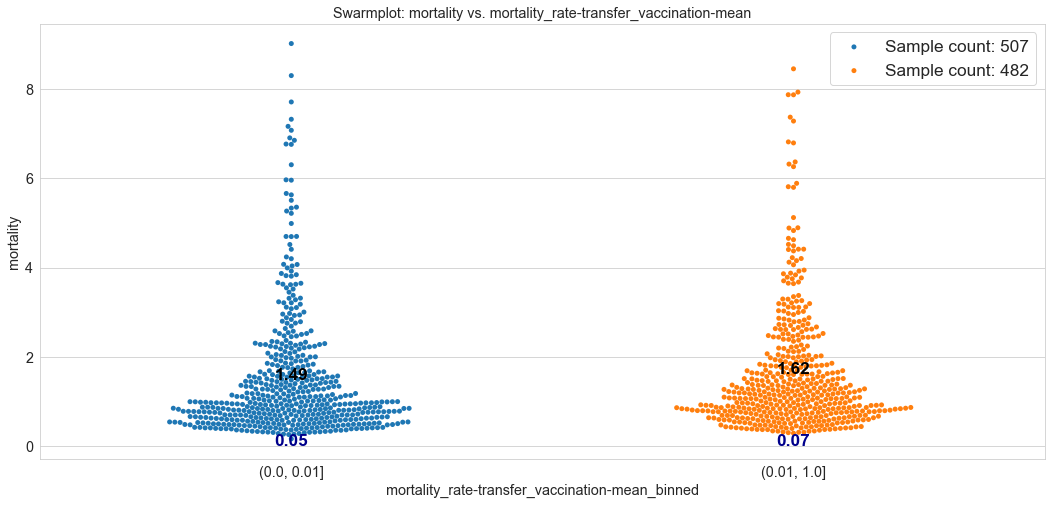

<Figure size 1080x360 with 0 Axes>

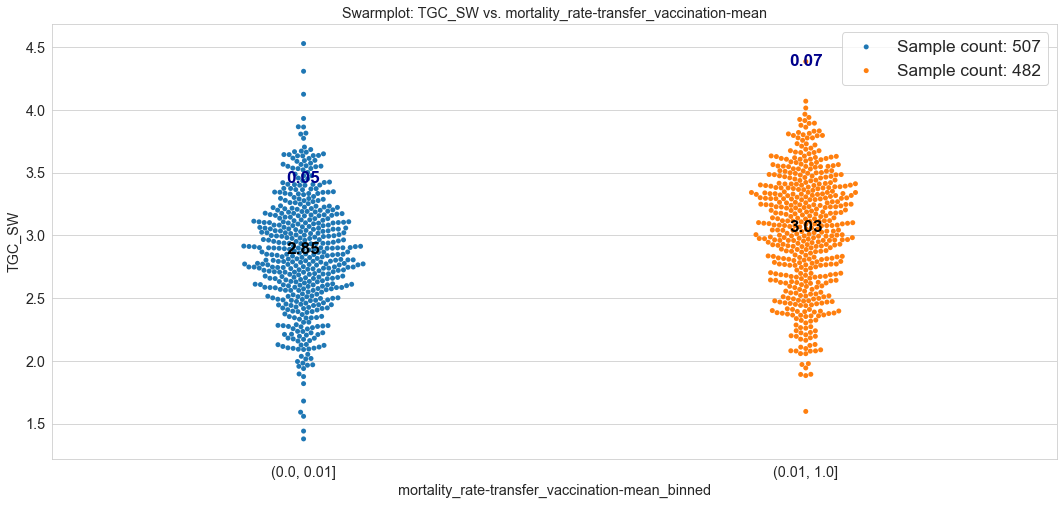

In [53]:
factor = f'{main_factor}-transfer_vaccination-mean'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.001][factor] * 100).hist()
plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.01, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.01, 1),
           y_scale=0.015)

### Finding 5: Min mortality rate whole period

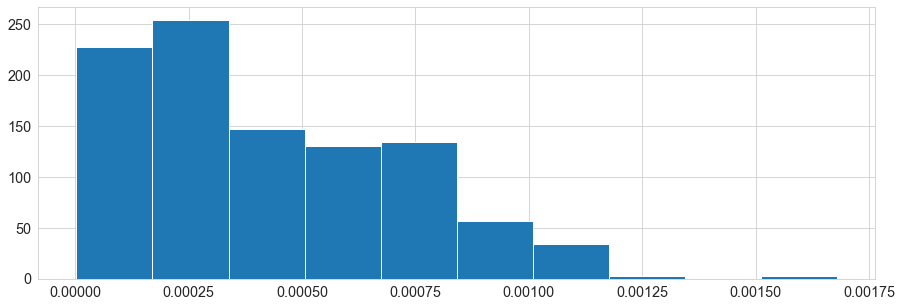

<Figure size 1080x360 with 0 Axes>

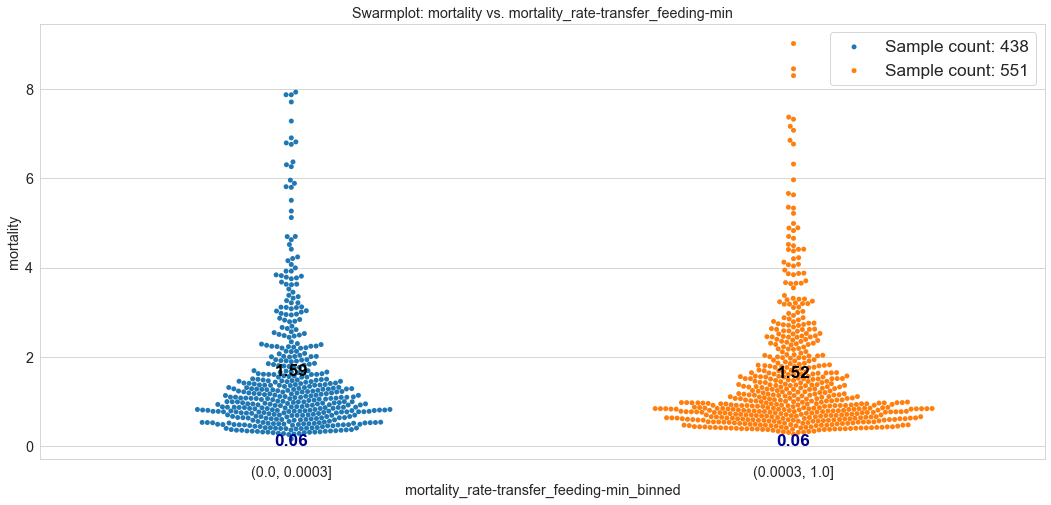

<Figure size 1080x360 with 0 Axes>

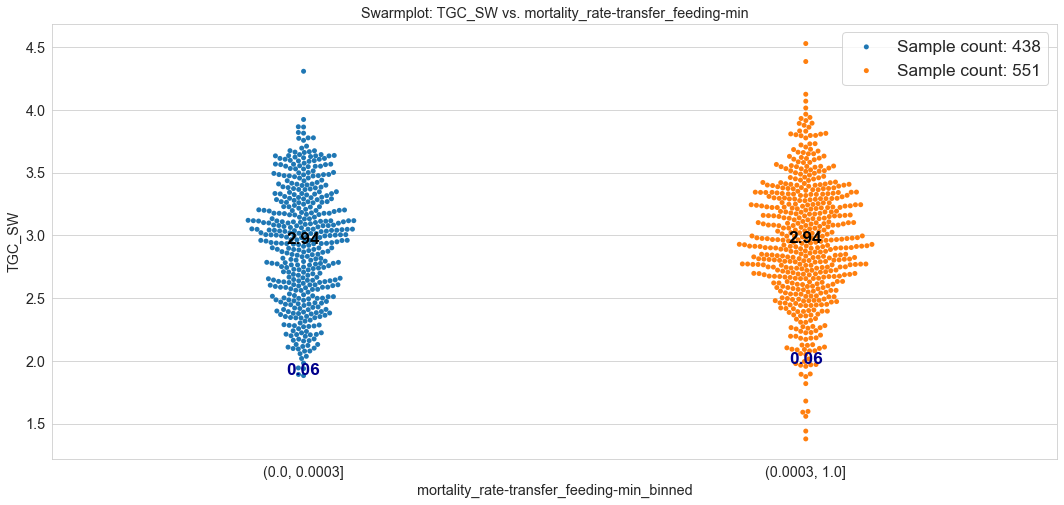

In [56]:
factor = f'{main_factor}-transfer_feeding-min'

(factors_fw_mortality[factor] * 100).hist()

plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 0.0003, 1),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 0.0003, 1),
           y_scale=0.03)

### Finding 6: Max mortality rate whole period

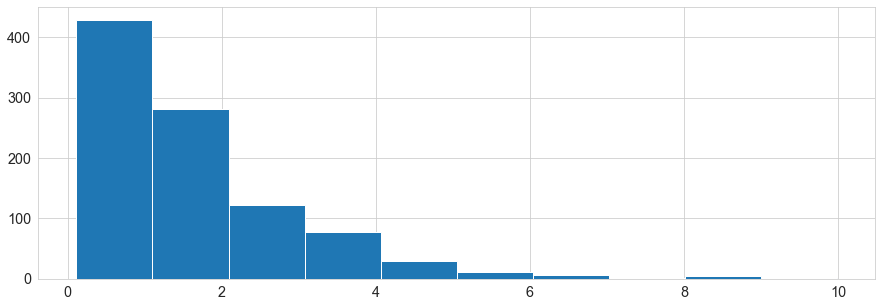

<Figure size 1080x360 with 0 Axes>

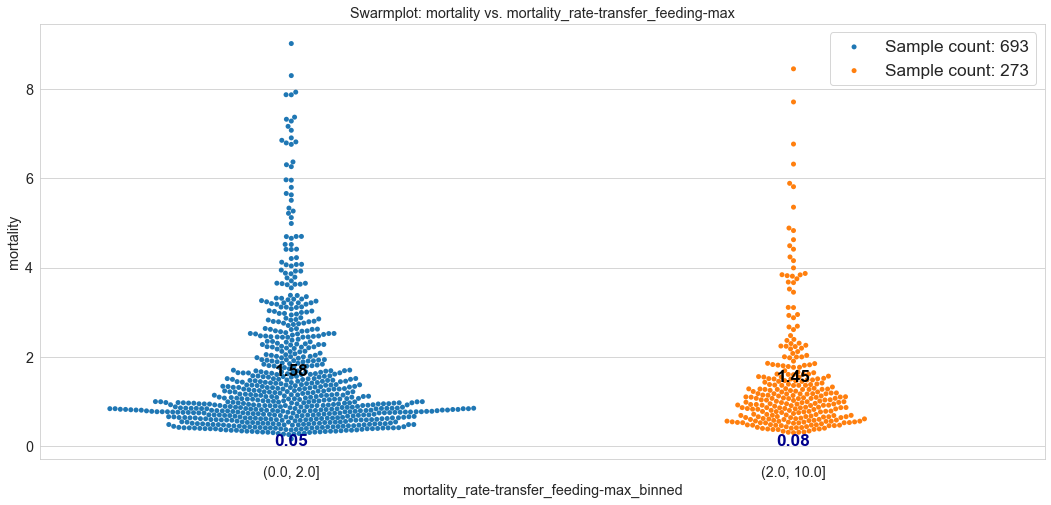

<Figure size 1080x360 with 0 Axes>

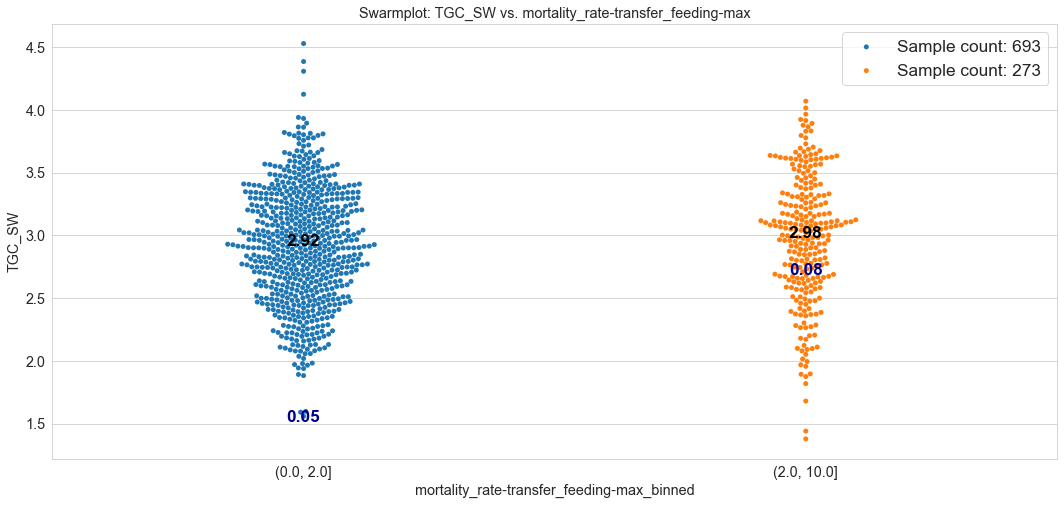

In [69]:
factor = f'{main_factor}-transfer_feeding-max'

(factors_fw_mortality[factors_fw_mortality[factor] < 0.1][factor] * 100).hist() 

plt.show()

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='mortality',
           bins=(0., 2, 10),
           y_scale=5)

plot_swarm(factors_fw_mortality * 100,
           factor=factor,
           target='TGC_SW',
           bins=(0., 2, 10),
           y_scale=0.03)

### Finding 7: CV for mortality rate whole period

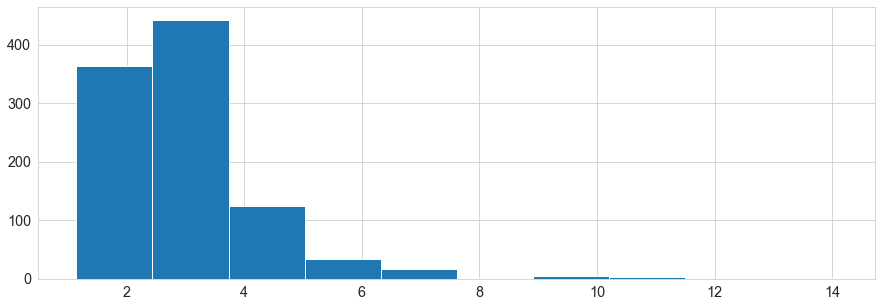

<Figure size 1080x360 with 0 Axes>

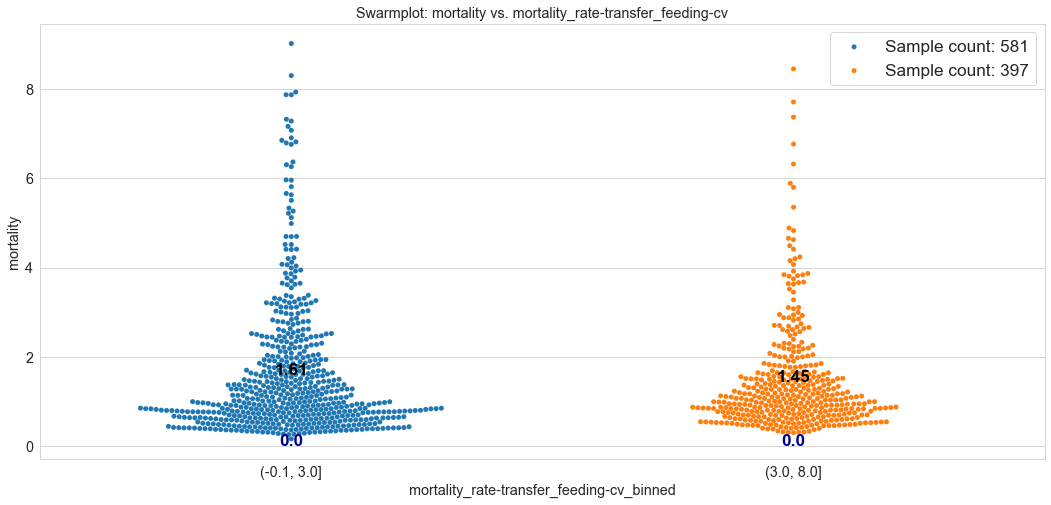

<Figure size 1080x360 with 0 Axes>

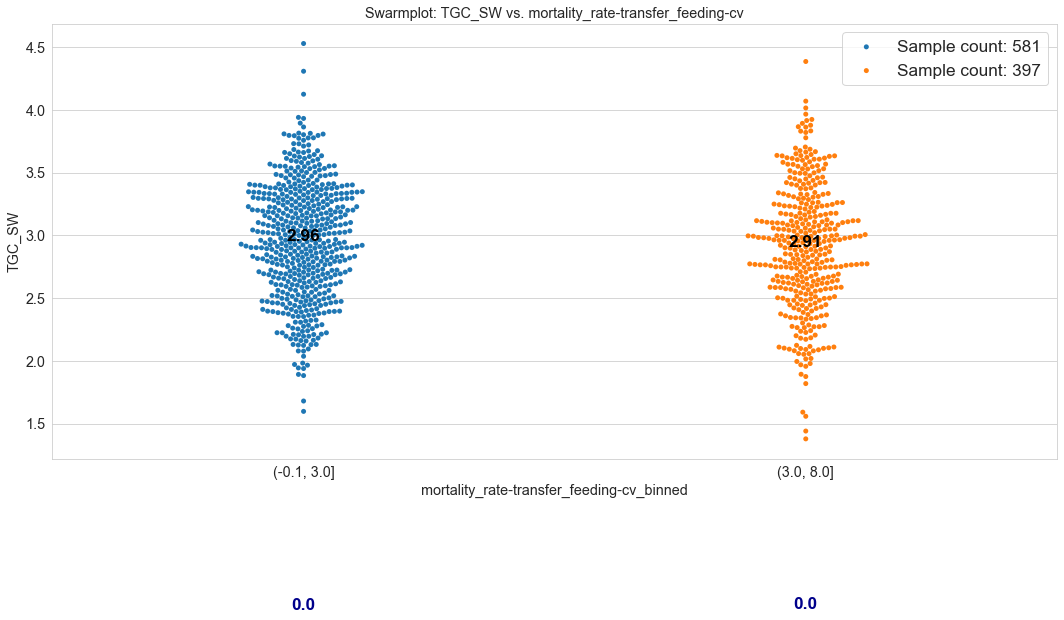

In [81]:
factor = f'{main_factor}-transfer_feeding-cv'

factors_fw_mortality[factor].hist()
plt.show()

temporary_df = factors_fw_mortality.copy()
temporary_df['TGC_SW'] = temporary_df['TGC_SW'] * 100  # see plot_swarm
temporary_df['mortality'] = temporary_df['mortality'] * 100  # see plot_swarm

plot_swarm(temporary_df,
           factor=factor,
           target='mortality',
           bins=(-0.1, 3, 8),
           y_scale=5)

plot_swarm(temporary_df,
           factor=factor,
           target='TGC_SW',
           bins=(-0.1, 3, 8),
           y_scale=0.03)